# **Faster R-CNN **
is a two-stage object detector:


Stage 1: Region Proposal Network (RPN)

Takes feature maps from a CNN backbone (e.g., ResNet).
Generates region proposals (areas likely to contain objects).



Stage 2: ROI Pooling + Classification

Each proposed region is cropped and resized.
A classifier predicts the object class and refines the bounding box.



Key Characteristics:

Two-stage (proposal + classification)
High accuracy, especially for small objects
Slower than YOLO because of extra steps
Applications: Medical imaging, high-precision tasks, research.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor   # torch, torchvision: PyTorch deep learning framework
import torch.utils.data as data
from PIL import Image     # - PIL: Image loading
import random
from torch.utils.data import DataLoader
import time
import json
from collections import defaultdict

# ARCHITECTURE OVERVIEW:
Input Image (e.g., 800x600)
     ↓
1. BACKBONE (Feature Extractor)
   - Usually ResNet-50 or ResNet-101
   - Extracts feature maps from image
   - Like: "Find all patterns in the image"
     ↓
2. RPN (Region Proposal Network) - STAGE 1
   - Slides over feature maps
   - Proposes ~2000 candidate boxes
   - Predicts: "Is there an object here?"
   - Outputs: [x, y, w, h, objectness_score]
     ↓
3. ROI POOLING
   - Crops features for each proposal
   - Resizes to fixed size (e.g., 7x7)
   - Prepares for classification
     ↓
4. DETECTION HEAD - STAGE 2
   - Classifies each region
   - Refines bounding box
   - Outputs: [class, confidence, refined_bbox]
     ↓
5. NMS (Non-Maximum Suppression)
   - Removes duplicate detections
   - Keeps best box per object
     ↓
Final Detections

# visualizatoin to understande the R-CNN architectures

FASTER R-CNN ARCHITECTURE EXPLAINED



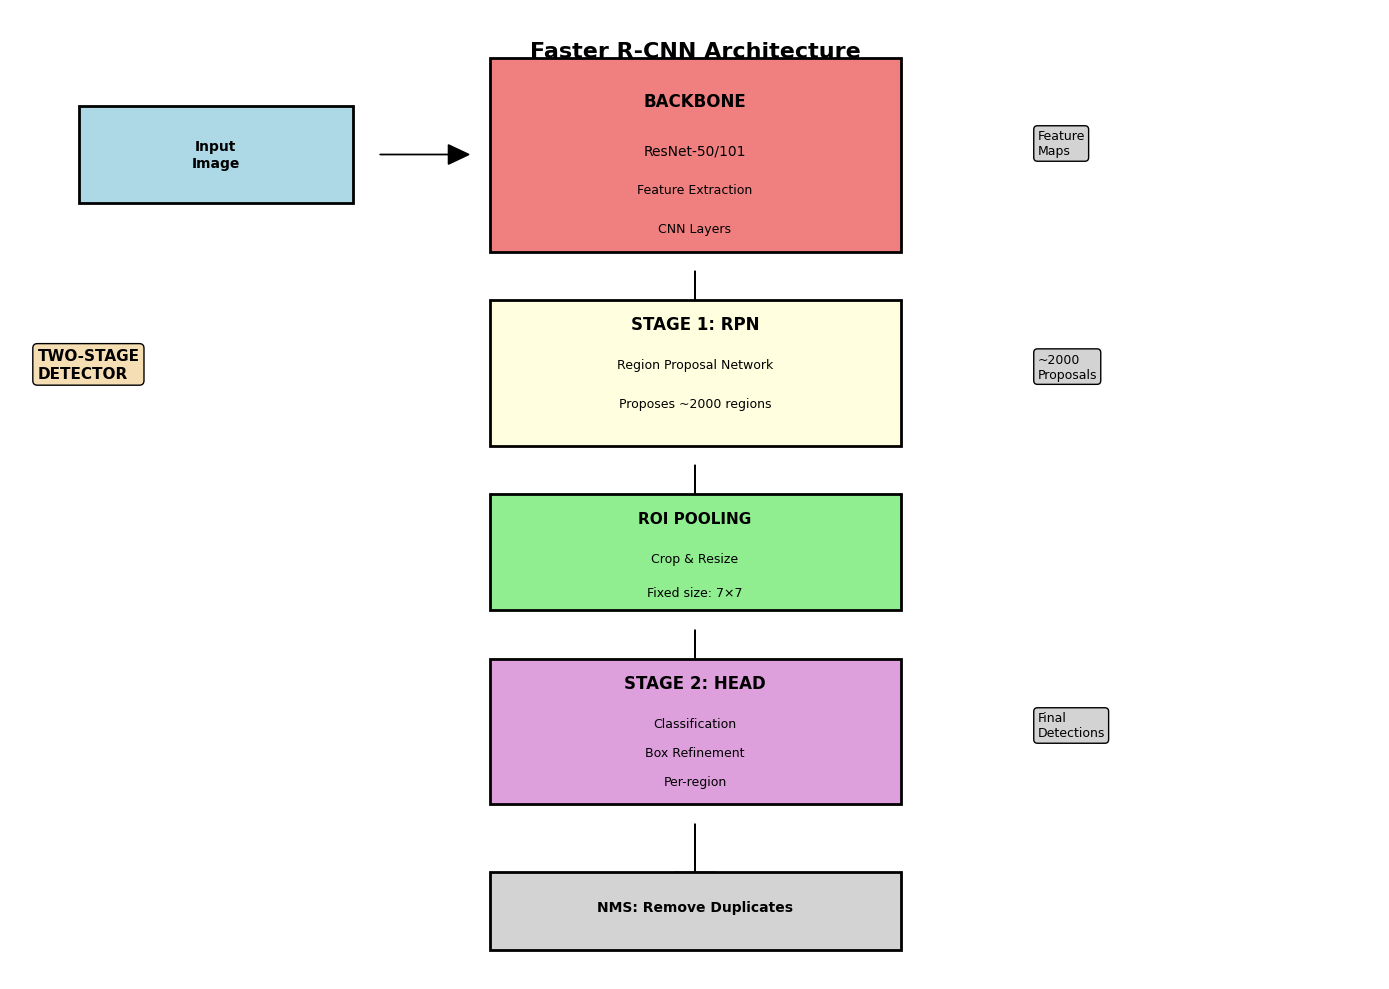

In [ ]:


print("="*60)
print("FASTER R-CNN ARCHITECTURE EXPLAINED")
print("="*60)
print()

# Create architecture visualization
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(5, 9.5, 'Faster R-CNN Architecture',
        ha='center', fontsize=16, fontweight='bold')

# Input
ax.add_patch(plt.Rectangle((0.5, 8), 2, 1,
             facecolor='lightblue', edgecolor='black', linewidth=2))
ax.text(1.5, 8.5, 'Input\nImage', ha='center', va='center', fontweight='bold')

# Arrow
ax.arrow(2.7, 8.5, 0.5, 0, head_width=0.2, head_length=0.15, fc='black', ec='black')

# Backbone
ax.add_patch(plt.Rectangle((3.5, 7.5), 3, 2,
             facecolor='lightcoral', edgecolor='black', linewidth=2))
ax.text(5, 9, 'BACKBONE', ha='center', fontweight='bold', fontsize=12)
ax.text(5, 8.5, 'ResNet-50/101', ha='center', fontsize=10)
ax.text(5, 8.1, 'Feature Extraction', ha='center', fontsize=9)
ax.text(5, 7.7, 'CNN Layers', ha='center', fontsize=9)

# Arrow to RPN
ax.arrow(5, 7.3, 0, -0.5, head_width=0.3, head_length=0.15, fc='black', ec='black')

# RPN - Stage 1
ax.add_patch(plt.Rectangle((3.5, 5.5), 3, 1.5,
             facecolor='lightyellow', edgecolor='black', linewidth=2))
ax.text(5, 6.7, 'STAGE 1: RPN', ha='center', fontweight='bold', fontsize=12)
ax.text(5, 6.3, 'Region Proposal Network', ha='center', fontsize=9)
ax.text(5, 5.9, 'Proposes ~2000 regions', ha='center', fontsize=9)

# Arrow to ROI Pooling
ax.arrow(5, 5.3, 0, -0.5, head_width=0.3, head_length=0.15, fc='black', ec='black')

# ROI Pooling
ax.add_patch(plt.Rectangle((3.5, 3.8), 3, 1.2,
             facecolor='lightgreen', edgecolor='black', linewidth=2))
ax.text(5, 4.7, 'ROI POOLING', ha='center', fontweight='bold', fontsize=11)
ax.text(5, 4.3, 'Crop & Resize', ha='center', fontsize=9)
ax.text(5, 3.95, 'Fixed size: 7×7', ha='center', fontsize=9)

# Arrow to Head
ax.arrow(5, 3.6, 0, -0.5, head_width=0.3, head_length=0.15, fc='black', ec='black')

# Detection Head - Stage 2
ax.add_patch(plt.Rectangle((3.5, 1.8), 3, 1.5,
             facecolor='plum', edgecolor='black', linewidth=2))
ax.text(5, 3, 'STAGE 2: HEAD', ha='center', fontweight='bold', fontsize=12)
ax.text(5, 2.6, 'Classification', ha='center', fontsize=9)
ax.text(5, 2.3, 'Box Refinement', ha='center', fontsize=9)
ax.text(5, 2.0, 'Per-region', ha='center', fontsize=9)

# Arrow to NMS
ax.arrow(5, 1.6, 0, -0.5, head_width=0.3, head_length=0.15, fc='black', ec='black')

# NMS
ax.add_patch(plt.Rectangle((3.5, 0.3), 3, 0.8,
             facecolor='lightgray', edgecolor='black', linewidth=2))
ax.text(5, 0.7, 'NMS: Remove Duplicates', ha='center', fontweight='bold', fontsize=10)

# Side annotations
ax.text(0.2, 6.2, 'TWO-STAGE\nDETECTOR', fontsize=11, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='wheat'))

ax.text(7.5, 8.5, 'Feature\nMaps', fontsize=9,
       bbox=dict(boxstyle='round', facecolor='lightgray'))

ax.text(7.5, 6.2, '~2000\nProposals', fontsize=9,
       bbox=dict(boxstyle='round', facecolor='lightgray'))

ax.text(7.5, 2.5, 'Final\nDetections', fontsize=9,
       bbox=dict(boxstyle='round', facecolor='lightgray'))

plt.tight_layout()
plt.show()



In [ ]:
print("🔹 BACKBONE (ResNet-50):")
print("   - Deep CNN with 50 layers")
print("   - Extracts hierarchical features")
print("   - Pretrained on ImageNet (1M images)")
print()
print("🔹 RPN (Region Proposal Network):")
print("   - Learns WHERE objects might be")
print("   - Uses 'anchor boxes' at different scales")
print("   - Outputs: objectness score + rough box")
print()
print("🔹 ROI POOLING:")
print("   - Crops feature map for each proposal")
print("   - Resizes to fixed size (7×7×512)")
print("   - Allows batch processing")
print()
print("🔹 DETECTION HEAD:")
print("   - Fully connected layers")
print("   - Classifies: What is it?")
print("   - Regresses: Refine box coordinates")
print()
print("🔹 NMS (Non-Maximum Suppression):")
print("   - Removes overlapping boxes")
print("   - Keeps highest confidence per object")
print("   - IoU threshold: typically 0.5")
print()
print("="*60)
print()
print("✓ Architecture understanding complete!")
print("✓ Faster R-CNN = Accuracy > Speed")

🔹 BACKBONE (ResNet-50):
   - Deep CNN with 50 layers
   - Extracts hierarchical features
   - Pretrained on ImageNet (1M images)

🔹 RPN (Region Proposal Network):
   - Learns WHERE objects might be
   - Uses 'anchor boxes' at different scales
   - Outputs: objectness score + rough box

🔹 ROI POOLING:
   - Crops feature map for each proposal
   - Resizes to fixed size (7×7×512)
   - Allows batch processing

🔹 DETECTION HEAD:
   - Fully connected layers
   - Classifies: What is it?
   - Regresses: Refine box coordinates

🔹 NMS (Non-Maximum Suppression):
   - Removes overlapping boxes
   - Keeps highest confidence per object
   - IoU threshold: typically 0.5


✓ Architecture understanding complete!
✓ Faster R-CNN = Accuracy > Speed


In [ ]:
import zipfile


zip_path = "road_detection_datasetV2.zip"     # Change this to your actual zip file name
extract_dir = "dataset"           # Where to extract your files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
dataset_path = "dataset"  # Your YOLO-format dataset folder

# Paths to splits
train_images = os.path.join(dataset_path, "train", "images")
train_labels = os.path.join(dataset_path, "train", "labels")

valid_images = os.path.join(dataset_path, "valid", "images")
valid_labels = os.path.join(dataset_path, "valid", "labels")

test_images = os.path.join(dataset_path, "test", "images")
test_labels = os.path.join(dataset_path, "test", "labels")

# Path to data.yaml
data_yaml_path = os.path.join(dataset_path, "data.yaml")


In [ ]:
print("FORMAT CONVERSION:")
print("  YOLO format: class_id center_x center_y width height")
print("   → Faster R-CNN needs: [x1, y1, x2, y2] in pixels")
print()
print("  We'll convert automatically during training!")
print("   • center_x, center_y → calculate corners")
print("   • width, height → calculate x2, y2")
print("   • Normalize (0-1) → Pixel coordinates")

FORMAT CONVERSION:
  YOLO format: class_id center_x center_y width height
   → Faster R-CNN needs: [x1, y1, x2, y2] in pixels

  We'll convert automatically during training!
   • center_x, center_y → calculate corners
   • width, height → calculate x2, y2
   • Normalize (0-1) → Pixel coordinates


In [ ]:
import  yaml

if os.path.exists(data_yaml_path):
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Extract class information
    num_classes = data_config.get('nc', 0)
    class_names = data_config.get('names', [])

    print(f"Number of classes: {num_classes}")
    print()
    print("Class mapping:")
    for idx, name in enumerate(class_names):
        print(f"  {idx}: {name}")
    print()
    print("   Faster R-CNN uses class 0 for 'background'")
    print("  so we need to shifte our classes so the background will ne asiend to 0 index")
# add +1 to all classes index to preserve the 0 index for the background
    num_classes_with_bg = num_classes + 1
    label_map = {0: 'background'}
    for idx, name in enumerate(class_names):
        label_map[idx + 1] = name
    print(f"✓ Total classes for Faster R-CNN: {num_classes_with_bg}")
    print("   Original YOLO → Faster R-CNN")
    for idx, name in enumerate(class_names):
        print(f"   Class {idx} ({name}) → Class {idx + 1}")
    print()

Number of classes: 7

Class mapping:
  0: bicycles
  1: buses
  2: crosswalks
  3: fire hydrants
  4: motorcycles
  5: traffic lights
  6: vehicles

   Faster R-CNN uses class 0 for 'background'
  so we need to shifte our classes so the background will ne asiend to 0 index
✓ Total classes for Faster R-CNN: 8
   Original YOLO → Faster R-CNN
   Class 0 (bicycles) → Class 1
   Class 1 (buses) → Class 2
   Class 2 (crosswalks) → Class 3
   Class 3 (fire hydrants) → Class 4
   Class 4 (motorcycles) → Class 5
   Class 5 (traffic lights) → Class 6
   Class 6 (vehicles) → Class 7



# CREATE CUSTOM DATASET CLASS

PyTorch needs a Dataset class to load data.
This class:
1. Reads images
2. Reads YOLO labels
3. Converts YOLO format → Faster R-CNN format
4. Returns in the format Faster R-CNN expects

# the  converting part

YOLO format: class_id center_x center_y width height (normalized 0-1)
Faster R-CNN needs:
  - boxes: [[x1, y1, x2, y2], ...] in PIXELS
  - labels: [class_id, ...] (with background as 0)
  - image_id: unique ID for each image

In [ ]:

class RoadDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        self.image_files = [f for f in os.listdir(images_dir)
                            if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        img_width, img_height = image.size

        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.labels_dir, label_name)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:  # <-- (replace &gt;= with >= in your code)
                        class_id = int(parts[0])
                        center_x = float(parts[1])
                        center_y = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        # ✅ Skip broken YOLO annotations
                        if width <= 0 or height <= 0:
                            continue

                        # YOLO normalized -> pixel
                        x_center = center_x * img_width
                        y_center = center_y * img_height
                        w = width * img_width
                        h = height * img_height

                        x1 = x_center - w / 2
                        y1 = y_center - h / 2
                        x2 = x_center + w / 2
                        y2 = y_center + h / 2

                        # ✅ Clamp inside image (use -1)
                        x1 = max(0.0, min(x1, img_width - 1.0))
                        y1 = max(0.0, min(y1, img_height - 1.0))
                        x2 = max(0.0, min(x2, img_width - 1.0))
                        y2 = max(0.0, min(y2, img_height - 1.0))

                        # ✅ Filter invalid/tiny boxes to prevent AssertionError
                        min_size = 1.0
                        if (x2 - x1) < min_size or (y2 - y1) < min_size:
                            # Optional debug:
                            # print("⚠️ Dropping invalid box:", img_path, line.strip(), (x1,y1,x2,y2))
                            continue

                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id + 1)  # background is 0

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        # Convert image to tensor
        image = torchvision.transforms.functional.to_tensor(image)

        # Apply transforms (ONLY if your transform updates boxes correctly!)
        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


# What it does:
 1. __init__: Sets up file paths and lists
 2. __len__: Returns number of images
 3. __getitem__: Loads ONE image + labels
# Format conversion in __getitem__:
  • YOLO: [class_id, cx, cy, w, h] (normalized)
  
  • Faster R-CNN: {boxes: [[x1,y1,x2,y2]], labels: [class+1]}

###Now we create actual dataset objects using our custom class

# One for training, one for validation, one for testing

In [ ]:
print(" Creating dataset instances...")
print()

# Create training dataset
train_dataset = RoadDataset(
    images_dir=train_images,
    labels_dir=train_labels,
    transforms=None  # We'll add augmentation later if needed
)

# Create validation dataset
valid_dataset = RoadDataset(
    images_dir=valid_images,
    labels_dir=valid_labels,
    transforms=None
)

# Create test dataset
test_dataset = RoadDataset(
    images_dir=test_images,
    labels_dir=test_labels,
    transforms=None
)

 Creating dataset instances...



In [ ]:
print("="*60)
print("DATASET INSTANCES CREATED")
print("="*60)
print()
print(f"Training dataset:   {len(train_dataset)} images")
print(f"Validation dataset: {len(valid_dataset)} images")
print(f"Test dataset:       {len(test_dataset)} images")
print(f"Total:              {len(train_dataset) + len(valid_dataset) + len(test_dataset)} images")
print()

DATASET INSTANCES CREATED

Training dataset:   494 images
Validation dataset: 187 images
Test dataset:       133 images
Total:              814 images



In [ ]:
sample_img, sample_target = train_dataset[0]

print(f"✓ Sample loaded successfully!")
print(f"  Image shape: {sample_img.shape}")
print(f"  Image type: Tensor with values [0, 1]")
print(f"  Number of objects: {len(sample_target['boxes'])}")
if len(sample_target['boxes']) > 0:
    print(f"  First box: {sample_target['boxes'][0].tolist()}")
    print(f"  First label: {sample_target['labels'][0].item()}")
    print(f"    → Class: {label_map[sample_target['labels'][0].item()]}")

print()

✓ Sample loaded successfully!
  Image shape: torch.Size([3, 640, 640])
  Image type: Tensor with values [0, 1]
  Number of objects: 14
  First box: [323.75, 0.25, 388.25, 37.75]
  First label: 6
    → Class: traffic lights



## CREATE DATALOADERS


# DataLoader wraps the Dataset and provides:
 - **Batching**Groups multiple images together

- **Shuffling** Randomizes order each epoch
- **Parallel loading:** Uses multiple CPU cores
- **Collation:** Combines samples into batches


### For Faster R-CNN, we need a special collate function because:
- Different images have different numbers of objects
- Can't stack into regular tensor batches
- Need custom collation to handle variable-length lists

In [ ]:
def collate_fn(batch):
    """
    Custom collate function for Faster R-CNN

    Explanation:
    - Regular DataLoader expects all samples same shape
    - Our images have different numbers of objects
    - This function handles variable-length batches

    Parameters:
    - batch: List of (image, target) tuples

    Returns:
    - Tuple of (images_list, targets_list)
    """
    return tuple(zip(*batch))

print(" Creating DataLoaders...")
print()

 Creating DataLoaders...



In [ ]:
batch_size = 4  # Number of images per batch (reduce if GPU memory error)
num_workers = 4  # Parallel data loading processes

# Create training DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for randomness during training
    num_workers=num_workers,
    collate_fn=collate_fn,  # Our custom collate function
    pin_memory=True if torch.cuda.is_available() else False  # Faster GPU transfer
)

# Create validation DataLoader
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

# Create test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for testing
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Batch size: {batch_size} images per batch")
print(f"Number of workers: {num_workers} parallel processes")
print()
print(f"Training batches:   {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test batches:       {len(test_loader)}")
print()
print("="*60)

Batch size: 4 images per batch
Number of workers: 4 parallel processes

Training batches:   124
Validation batches: 47
Test batches:       34



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# VISUALIZE TRAINING DATA
WHAT YOU SEE:

  • Green boxes = Object bounding boxes

  • Labels = Class names

  • Boxes should fit objects tightly

In [ ]:
images, targets = next(iter(train_loader))

print(f"Loaded batch of {len(images)} images")
print()

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Training Data - Images with Bounding Boxes',
             fontsize=16, fontweight='bold')

for idx in range(min(4, len(images))):
    row = idx // 2
    col = idx % 2

    # Get image and target
    img = images[idx]
    target = targets[idx]

    # Convert tensor to numpy for visualization
    # Tensor is [C, H, W], we need [H, W, C] for matplotlib
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # Draw bounding boxes
    img_display = (img_np * 255).astype(np.uint8).copy()

    boxes = target['boxes'].cpu().numpy()
    labels = target['labels'].cpu().numpy()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box.astype(int)

        # Draw rectangle
        cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label text
        class_name = label_map.get(label, f"Class {label}")
        cv2.putText(img_display, class_name, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display
    axes[row, col].imshow(img_display)
    axes[row, col].set_title(f'Image {idx+1}: {len(boxes)} object(s)',
                            fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# MODEL CREATION, TRAINING SETUP & EXECUTION

# 1 LOAD PRETRAINED FASTER R-CNN MODEL

Loading pretrained Faster R-CNN with ResNet-50 backbone...

Pretrained on COCO datase

In [ ]:
# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

print("✓ Base model loaded!")
print()
print("🔧 Now modifying for YOUR dataset...")

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
# This allows us to classify into OUR specific classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes_with_bg)

print(f"✓ Modified for {num_classes_with_bg} classes (including background)")
print()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 173MB/s]


✓ Base model loaded!

🔧 Now modifying for YOUR dataset...
✓ Modified for 8 classes (including background)



# SET TRAINING HYPERPARAMETERS

🔹 num_epochs (10):

• Complete passes through dataset

• 10 is a good start, increase if needed

🔹 learning_rate (0.005):

• Step size for weight updates

• 0.005 is standard for fine-tuning

• Lower = slower but more stable

🔹 momentum (0.9):

• Helps SGD converge faster

• Uses velocity from previous steps

🔹 weight_decay (0.0005):

• L2 regularization

• Prevents overfitting

🔹 lr_step_size & lr_gamma:

• Decay learning rate during training

• LR × 0.1 every 3 epochs

• Helps fine-tune in later stages

In [ ]:
hyperparameters = {
    'num_epochs': 10,           # Number of training epochs
    'learning_rate': 0.005,     # Learning rate
    'momentum': 0.9,            # SGD momentum
    'weight_decay': 0.0005,     # L2 regularization
    'lr_step_size': 3,          # Decay LR every N epochs
    'lr_gamma': 0.1,            # LR decay factor
    'print_freq': 50,           # Print stats every N batches
}

print("📋 Configuration:")
for key, value in hyperparameters.items():
    print(f"  {key:20s}: {value}")


📋 Configuration:
  num_epochs          : 10
  learning_rate       : 0.005
  momentum            : 0.9
  weight_decay        : 0.0005
  lr_step_size        : 3
  lr_gamma            : 0.1
  print_freq          : 50


# CREATE OPTIMIZER & SCHEDULER

**Optimizer:** Choose the algorithm that updates the model’s weights (parameters) to reduce the loss.

**Scheduler:** Define how the learning rate should change over time (across epochs/steps) to improve training stability and final accuracy.

###we chossed
SGD (Stochastic Gradient Descent) is standard for Faster R-CNN

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=hyperparameters['learning_rate'],
    momentum=hyperparameters['momentum'],
    weight_decay=hyperparameters['weight_decay']
)

# Learning rate scheduler
# Reduces LR when learning plateaus
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=hyperparameters['lr_step_size'],
    gamma=hyperparameters['lr_gamma']
)

print("✓ Optimizer created: SGD")
print(f"  Initial LR: {hyperparameters['learning_rate']}")
print()
print("✓ Scheduler created: StepLR")
print(f"  Decay every {hyperparameters['lr_step_size']} epochs by {hyperparameters['lr_gamma']}x")

✓ Optimizer created: SGD
  Initial LR: 0.005

✓ Scheduler created: StepLR
  Decay every 3 epochs by 0.1x


# DEFINE TRAINING FUNCTION and the validation function

## in the trainning function :
    Train model for one epoch
    
    Explanation of training loop:
    1. Set model to training mode
    2. For each batch:
       a. Move data to GPU
       b. Forward pass: model predicts
       c. Calculate loss: how wrong are predictions?
       d. Backward pass: calculate gradients
       e. Update weights: improve model
    3. Return average loss

## in the validation function :
    Validate model on validation set
    
    Explanation:
    - Similar to training but NO weight updates
    - Just measure performance on unseen data
    - Used to check for overfitting

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()  # Set to training mode (enables dropout, etc.)

    total_loss = 0
    num_batches = len(data_loader)

    print(f"\nEpoch {epoch + 1}/{hyperparameters['num_epochs']}")
    print("-" * 60)

    for batch_idx, (images, targets) in enumerate(data_loader):
        # Move to device (GPU or CPU)
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Sum all losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()  # Clear old gradients
        losses.backward()      # Calculate gradients
        optimizer.step()       # Update weights

        # Track loss
        total_loss += losses.item()

        # Print progress
        if (batch_idx + 1) % hyperparameters['print_freq'] == 0 or (batch_idx + 1) == num_batches:
            avg_loss = total_loss / (batch_idx + 1)
            print(f"  Batch [{batch_idx+1}/{num_batches}] | "
                  f"Loss: {losses.item():.4f} | "
                  f"Avg Loss: {avg_loss:.4f}")

    return total_loss / num_batches

In [ ]:

import torch

def validate(model, data_loader, device):
    # Save current mode so we can restore it after validation
    was_training = model.training

    model.train()  # IMPORTANT: makes Faster R-CNN return loss dict
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)  # dict in train mode
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()
            num_batches += 1

    # Restore the model’s previous mode
    model.train(was_training)

    return total_loss / max(num_batches, 1)


# START TRAINING

In [ ]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Using device: cuda


In [ ]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(hyperparameters['num_epochs']):
    # Train
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, valid_loader, device)
    val_losses.append(val_loss)

    # Update learning rate
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Current LR: {current_lr:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'faster_rcnn_best.pth')
        print(f"  ✓ Best model saved!")

    print("="*60)

# Save final model
torch.save(model.state_dict(), 'faster_rcnn_final.pth')

print()
print("🎉 TRAINING COMPLETE!")
print(f"✓ Best validation loss: {best_val_loss:.4f}")
print("✓ Models saved:")
print("  • faster_rcnn_best.pth (best validation)")
print("  • faster_rcnn_final.pth (last epoch)")


Epoch 1/10
------------------------------------------------------------
  Batch [50/124] | Loss: 0.6220 | Avg Loss: 0.7329
  Batch [100/124] | Loss: 0.3498 | Avg Loss: 0.5909
  Batch [124/124] | Loss: 2.0613 | Avg Loss: 0.5708

Epoch 1 Summary:
  Train Loss: 0.5708
  Val Loss:   1.5404
  Current LR: 0.005000
  ✓ Best model saved!

Epoch 2/10
------------------------------------------------------------
  Batch [50/124] | Loss: 0.1588 | Avg Loss: 0.3981
  Batch [100/124] | Loss: 0.3171 | Avg Loss: 0.3744
  Batch [124/124] | Loss: 0.3445 | Avg Loss: 0.3699

Epoch 2 Summary:
  Train Loss: 0.3699
  Val Loss:   1.6824
  Current LR: 0.005000

Epoch 3/10
------------------------------------------------------------
  Batch [50/124] | Loss: 0.3942 | Avg Loss: 0.2859
  Batch [100/124] | Loss: 0.2881 | Avg Loss: 0.2878
  Batch [124/124] | Loss: 0.1146 | Avg Loss: 0.2914

Epoch 3 Summary:
  Train Loss: 0.2914
  Val Loss:   2.0217
  Current LR: 0.000500

Epoch 4/10
---------------------------------

# VISUALIZE TRAINING CURVES

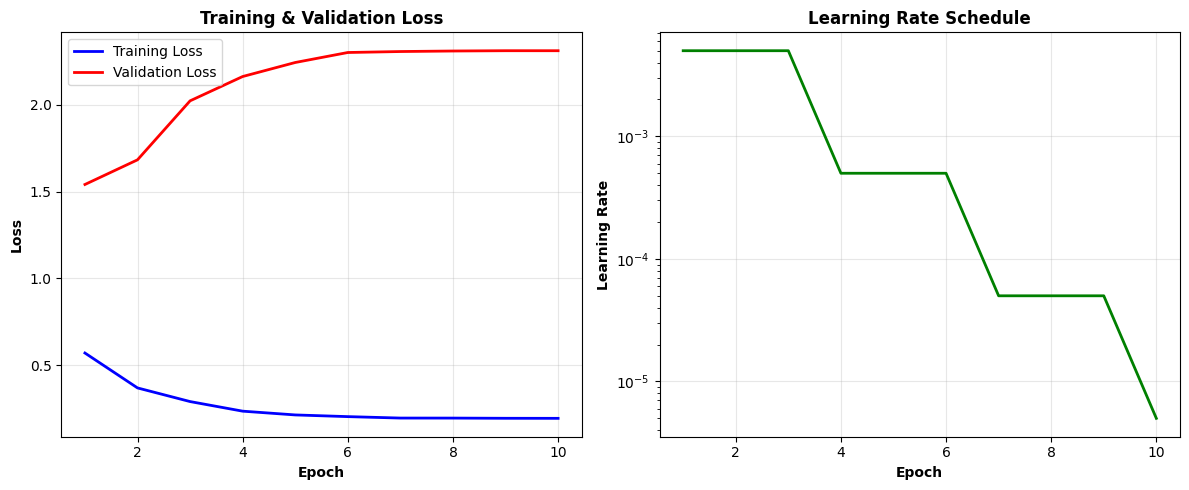

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Training & Validation Loss', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
learning_rates = [hyperparameters['learning_rate'] * (hyperparameters['lr_gamma'] ** (i // hyperparameters['lr_step_size']))
                  for i in range(hyperparameters['num_epochs'])]
plt.plot(range(1, len(learning_rates)+1), learning_rates, 'g-', linewidth=2)
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Learning Rate', fontweight='bold')
plt.title('Learning Rate Schedule', fontweight='bold')
plt.grid(alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

## load the best model

In [ ]:
model.load_state_dict(torch.load('faster_rcnn_best.pth'))
model.eval()
print("✓ Best model loaded for evaluation")

✓ Best model loaded for evaluation


# EVALUATION METRICS


In [ ]:

import torch, gc

def evaluate_model(model, data_loader, device, confidence_threshold=0.5):
    """
    Memory-safe evaluation for Faster R-CNN
    """
    model.eval()

    # If your model allows it, reduce memory via config:
    if hasattr(model, 'roi_heads'):
        # Limit number of final detections to reduce memory
        model.roi_heads.detections_per_img = min(getattr(model.roi_heads, 'detections_per_img', 100), 50)
    if hasattr(model, 'transform'):
        # Downscale images (adjust to your data)
        model.transform.min_size = (640,)   # short side target
        model.transform.max_size = 1024     # long side cap

    all_predictions = []
    all_targets = []

    print("\n🔍 Running evaluation...")

    # Disable grads + use mixed precision
    with torch.no_grad():
        for images, targets in data_loader:
            # Ensure images on device, keep targets on CPU
            images = [img.to(device, non_blocking=True) for img in images]

            # Mixed precision helps on Ampere+ GPUs
            with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):
                preds = model(images)

            # Filter by confidence & immediately move to CPU
            for pred in preds:
                scores = pred['scores'].detach()
                keep = scores > confidence_threshold

                filtered_pred = {
                    'boxes': pred['boxes'][keep].detach().cpu(),
                    'labels': pred['labels'][keep].detach().cpu(),
                    'scores': scores[keep].cpu()
                }
                all_predictions.append(filtered_pred)

            # Targets are typically dicts with CPU tensors; ensure CPU
            for t in targets:
                t_cpu = {
                    'boxes': t['boxes'].detach().cpu(),
                    'labels': t['labels'].detach().cpu()
                }
                all_targets.append(t_cpu)

            # Free GPU memory aggressively
            del preds, images
            torch.cuda.empty_cache()
            gc.collect()

    # Calculate simple metrics
    total_predictions = sum(len(p['boxes']) for p in all_predictions)
    total_targets = sum(len(t['boxes']) for t in all_targets)

    print(f"✓ Evaluation complete!")
    print(f"  Total predictions: {total_predictions}")
    print(f"  Total ground truth: {total_targets}")

    return all_predictions, all_targets


# TEST SET EVALUATION

In [ ]:

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=lambda batch: tuple(zip(*batch))   # required for detection models
)


In [ ]:
print("\n🏆 FINAL TEST RESULTS:")
print(f"  Test images: {len(test_dataset)}")
# print(f"  Total objects in ground truth: {sum(len(t['boxes']) for t in test_targets)}")
# print(f"  Total detections: {sum(len(p['boxes']) for p in test_predictions)}")


🏆 FINAL TEST RESULTS:
  Test images: 133


## VISUALIZE TEST PREDICTIONS

In [ ]:
model.eval()
test_samples = []
for i in random.sample(range(len(test_dataset)), min(9, len(test_dataset))):
    test_samples.append(test_dataset[i])

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Faster R-CNN Predictions on Test Set', fontsize=16, fontweight='bold')

for idx, (image, target) in enumerate(test_samples):
    row, col = idx // 3, idx % 3

    # Run prediction
    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    # Convert image to numpy
    img_np = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).copy()

    # Draw predictions (confidence > 0.5)
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

            class_name = label_map.get(label.item(), f"Class {label.item()}")
            text = f"{class_name}: {score:.2f}"
            cv2.putText(img_np, text, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    axes[row, col].imshow(img_np)
    axes[row, col].axis('off')
    num_detections = (prediction['scores'] > 0.5).sum().item()
    axes[row, col].set_title(f'{num_detections} detection(s)', fontweight='bold')

plt.tight_layout()
plt.show()
print("✓ Predictions visualized!")


# INFERENCE DEMO


📸 Running inference on demo image...


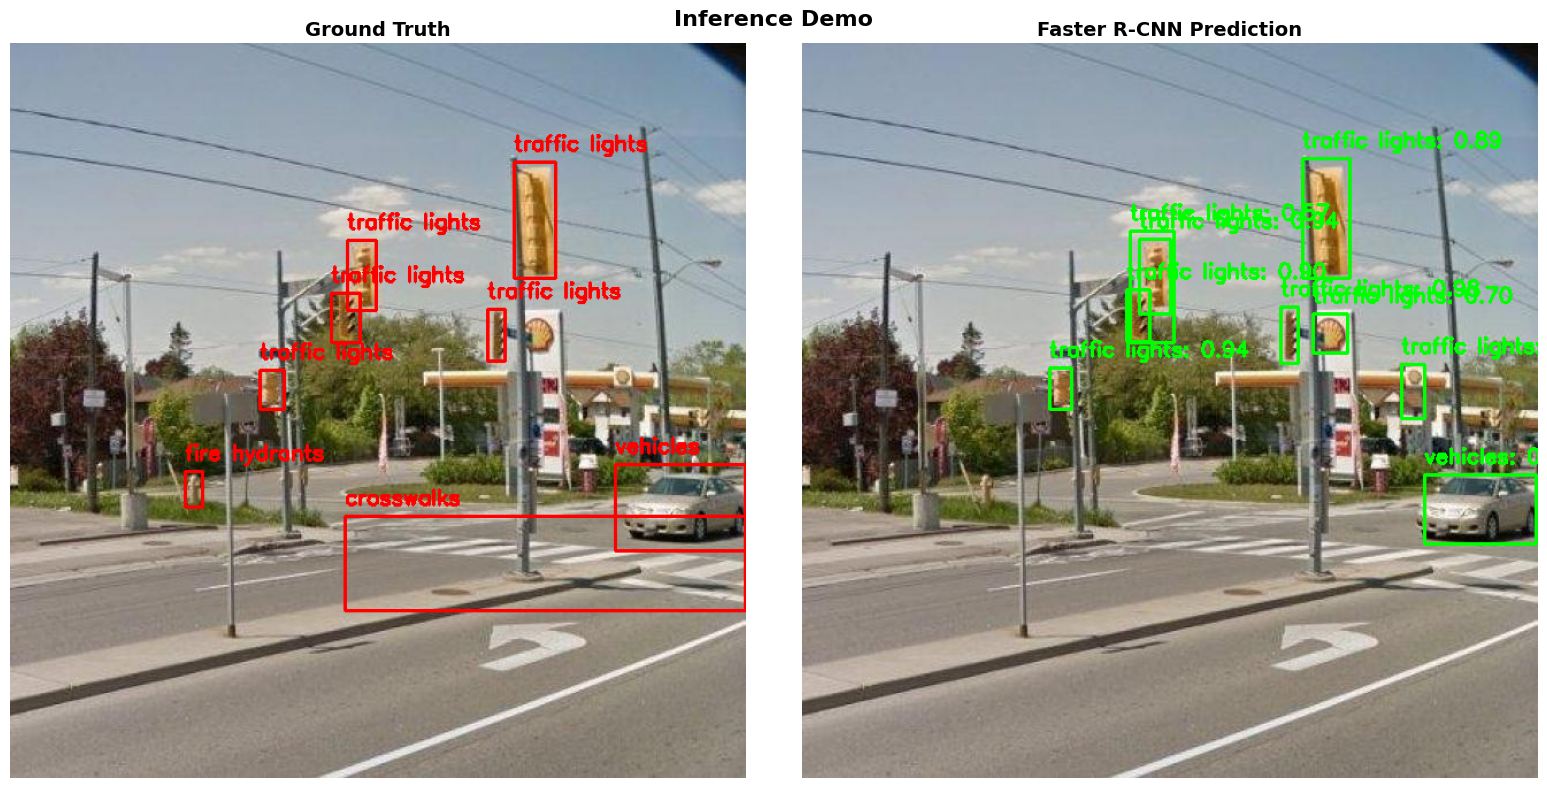


✓ Detection successful!
   • vehicles: 98.9%
   • traffic lights: 98.2%
   • traffic lights: 94.0%
   • traffic lights: 93.5%
   • traffic lights: 89.9%
   • traffic lights: 89.3%
   • traffic lights: 72.1%
   • traffic lights: 69.8%
   • traffic lights: 56.8%


In [ ]:
# Demo on single image
demo_img, demo_target = test_dataset[0]

print("\n📸 Running inference on demo image...")

with torch.no_grad():
    prediction = model([demo_img.to(device)])[0]

# Display
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original with ground truth
img_gt = (demo_img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).copy()
for box, label in zip(demo_target['boxes'], demo_target['labels']):
    x1, y1, x2, y2 = box.numpy().astype(int)
    cv2.rectangle(img_gt, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img_gt, label_map.get(label.item(), ''), (x1, y1-10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

axes[0].imshow(img_gt)
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Prediction
img_pred = (demo_img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).copy()
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box.cpu().numpy().astype(int)
        cv2.rectangle(img_pred, (x1, y1), (x2, y2), (0, 255, 0), 2)
        text = f"{label_map.get(label.item(), '')}: {score:.2f}"
        cv2.putText(img_pred, text, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

axes[1].imshow(img_pred)
axes[1].set_title('Faster R-CNN Prediction', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Inference Demo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

if (prediction['scores'] > 0.5).sum() > 0:
    print("\n✓ Detection successful!")
    for label, score in zip(prediction['labels'], prediction['scores']):
        if score > 0.5:
            print(f"   • {label_map.get(label.item(), 'Unknown')}: {score*100:.1f}%")
